In [1]:
freq = 16000
MAX_MFCC_LENGTH=100
MFCC_DIM=40
duration = 1

In [3]:
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import numpy as np
import pickle


print("recording started")
recording = sd.rec(int(duration * freq), 
                   samplerate=freq, channels=1)

sd.wait()
print("recording ended")
wv.write("record.wav", recording, freq, sampwidth=1)

recording = np.squeeze(recording)
print(recording.shape)
mel_spectrogram = librosa.feature.melspectrogram(y=recording, sr=freq, n_fft=400, hop_length=160, n_mels=MFCC_DIM)
mel_spectrogram += 1e-6 
log_mel_spectrogram = np.log(mel_spectrogram)
mfcc = librosa.feature.mfcc(S=log_mel_spectrogram, n_mfcc=MFCC_DIM)

mfcc = np.pad(mfcc, ((0, 0), (0, max(0, MAX_MFCC_LENGTH - mfcc.shape[1]))), mode='constant')[:, :MAX_MFCC_LENGTH]
mfcc = mfcc.astype(np.float16)  

# THIS IS IMPORTANT (NOT SURE IF CORRECT)
mfcc = mfcc[1:]
# mfcc = np.array(mfcc, dtype=np.float16)
print(mfcc.shape)
mfcc = np.expand_dims(mfcc, axis=0)  
print(mfcc.shape)



recording started
recording ended
(16000,)
(39, 100)
(1, 39, 100)


In [4]:
model = tf.keras.models.load_model("64-5x5_max2_128-4x4_max2_128-3x3_glob_256_0.5dropout_20ep.h5")

In [ ]:
import librosa
import os
import random
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as ipd


base_dir = os.path.join(os.getcwd(), "speech_commands_v0.02")
command_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
random_command = random.choice(command_folders)
random_command_path = os.path.join(base_dir, random_command)
files = [f for f in os.listdir(random_command_path) if os.path.isfile(os.path.join(random_command_path, f))]
random_file = random.choice(files)
random_file_path = os.path.join(random_command_path, random_file)

print(f"Selected Command Folder: {random_command}")

recording, sr = librosa.load(random_file_path, sr=16000)
print(f"Selected File: {random_file}")

ipd.Audio(recording, rate=sr)

# mfcc= librosa.feature.mfcc(y=recording,sr=freq, n_mfcc=MFCC_DIM)
# mfcc = np.pad(mfcc, ((0, 0), (0, max(0, MAX_MFCC_LENGTH - mfcc.shape[1]))), mode='constant')[:, :MAX_MFCC_LENGTH]
mel_spectrogram = librosa.feature.melspectrogram(y=recording, sr=freq, n_fft=400, hop_length=160, n_mels=MFCC_DIM)
mel_spectrogram += 1e-6 
log_mel_spectrogram = np.log(mel_spectrogram)
mfcc = librosa.feature.mfcc(S=log_mel_spectrogram, n_mfcc=MFCC_DIM)

mfcc = np.pad(mfcc, ((0, 0), (0, max(0, MAX_MFCC_LENGTH - mfcc.shape[1]))), mode='constant')[:, :MAX_MFCC_LENGTH]
mfcc = mfcc.astype(np.float16)  

# THIS IS IMPORTANT (NOT SURE IF CORRECT)
mfcc = mfcc[1:]
# mfcc = np.array(mfcc, dtype=np.float16)
print(mfcc.shape)
mfcc = np.expand_dims(mfcc, axis=0)  
print(mfcc.shape)

Selected Command Folder: right
Selected File: 3291330e_nohash_0.wav
(39, 100)
(1, 39, 100)


In [7]:
import IPython.display as ipd
ipd.Audio(recording, rate=freq)

Label encoder loaded.
1/1 [==============================] - 6s 6s/step


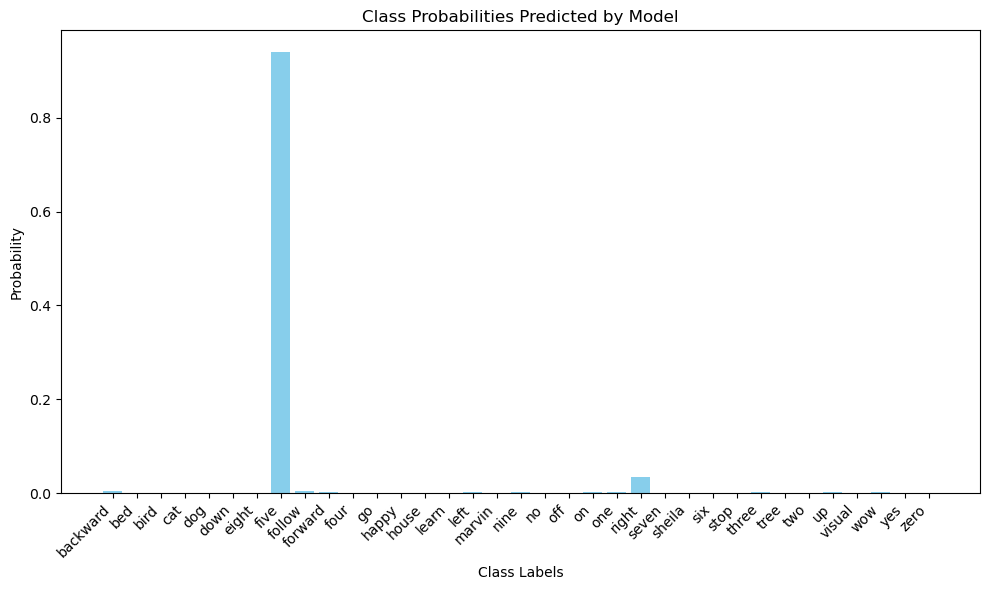

In [8]:
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)
print("Label encoder loaded.")

# Perform model prediction
predictions = model.predict(mfcc)  # Shape: (1, num_classes)
# print(f"Raw predictions: {predictions}")

# Extract probabilities for all classes
probabilities = predictions[0]  # Remove batch dimension
# print(f"Class probabilities: {probabilities}")

# Decode class labels
class_labels = label_encoder.inverse_transform(range(len(probabilities)))

# Plot probabilities in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_labels, probabilities, color='skyblue')
plt.xlabel("Class Labels")
plt.ylabel("Probability")
plt.title("Class Probabilities Predicted by Model")
plt.xticks(rotation=45, ha="right")  # Rotate labels for better visibility
plt.tight_layout()
plt.show()